This notebook demonstrates the simple usage of pretrained foundation model backbones on an image classification task with parameter efficient fine tuning. We use LoRA (low rank adaptation) as example. It includes:
- Load a classification dataset
- Load a pretrained foundation model as encoder
- Build a classification task head
- Build LoRA adaptors
- Finetune the head and adaptors while freezing the encoder
- Test the trained model for quantitative performance metrics
- Inference on some samples



In [ ]:
# install dependencies
!pip install -q torchgeo # for dataset and some supported models
!pip install peft # for lora finetuning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.3/605.3 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 112.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.3/859.3 kB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 824.2/824.2 kB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 107.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.6/507.6 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# import basic libraries
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

# check device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Load dataset

We use the CopernicusBench-EuroSAT-S1 dataset for example. This dataset is a classification dataset based on Sentinel-1 images (2 bands, 10m resolution, 64x64 pixels), each image falling into 1 of 10 land use land cover classes.

In [ ]:
from torchgeo.datasets import CopernicusBenchEuroSATS1
import kornia as K

mean = [-12.548, -20.192]
std = [5.257, 5.912]

transforms_train = K.augmentation.AugmentationSequential(
  K.augmentation.RandomResizedCrop(size=(64,64), scale=(0.8,1.0)),
  K.augmentation.RandomHorizontalFlip(p=0.5),
  K.augmentation.Normalize(mean=mean, std=std),
  data_keys=None,
  keepdim=True,
)

transforms_test = K.augmentation.AugmentationSequential(
  K.augmentation.Resize(size=(64,64), align_corners=True),
  K.augmentation.Normalize(mean=mean, std=std),
  data_keys=None,
  keepdim=True,
)

# Load the dataset as a Pytorch Dataset
dataset_train = CopernicusBenchEuroSATS1(root='data', split='train', bands=None, transforms=transforms_train, download=True, checksum=False)
dataset_val = CopernicusBenchEuroSATS1(root='data', split='val', bands=None, transforms=transforms_test, download=True, checksum=False)
dataset_test = CopernicusBenchEuroSATS1(root='data', split='test', bands=None, transforms=transforms_test, download=True, checksum=False)

100%|██████████| 921M/921M [00:19<00:00, 46.5MB/s]


dict_keys(['image', 'label', 'lat', 'lon'])
torch.Size([2, 64, 64]) tensor(3) tensor(38.0040) tensor(-0.9759)


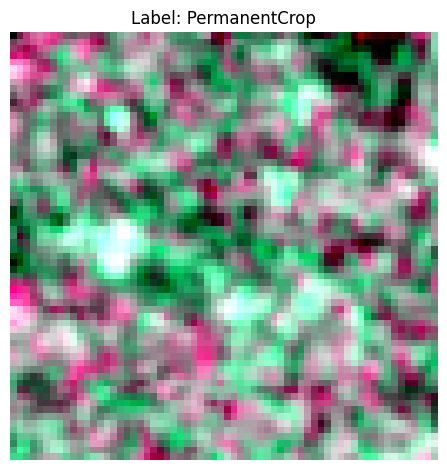

In [ ]:
# check and visualize some data
sample = dataset_train[3]
print(sample.keys())
print(sample['image'].shape, sample['label'], sample['lat'], sample['lon'])

dataset_train.plot(sample).show()

In [ ]:
# create dataloader
dataloader_train = DataLoader(dataset_train, batch_size=16, num_workers=2, drop_last=True)
dataloader_val = DataLoader(dataset_val, batch_size=16, num_workers=2, drop_last=False)
dataloader_test = DataLoader(dataset_test, batch_size=16, num_workers=2, drop_last=False)

## Load pretrained foundation model
In this demo, we choose [Copernicus-FM](https://github.com/zhu-xlab/Copernicus-FM/tree/main/Copernicus-FM) as the foundation model used here. We simply load the model from TorchGeo.

In [ ]:
from torchgeo.models import copernicusfm_base,CopernicusFM_Base_Weights
encoder = copernicusfm_base(weights=CopernicusFM_Base_Weights.CopernicusFM_ViT)

Downloading: "https://huggingface.co/torchgeo/copernicus-fm/resolve/f395812cc990ba25a451dbb9c9e6d95c8482947e/CopernicusFM_ViT_base_varlang-085350e4.pth" to /root/.cache/torch/hub/checkpoints/CopernicusFM_ViT_base_varlang-085350e4.pth


100%|██████████| 532M/532M [00:06<00:00, 85.1MB/s]


In [ ]:
print(encoder)

CopernicusFM(
  (fc_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (patch_embed_spectral): DynamicPatchEmbed(
    (spectrum_central_expansion): FourierExpansion()
    (spectrum_bandwidth_expansion): FourierExpansion()
    (weight_generator): TransformerWeightGenerator(
      (transformer_encoder): TransformerEncoder(
        (layers): ModuleList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
            )
            (linear1): Linear(in_features=128, out_features=2048, bias=True)
            (dropout): Dropout(p=False, inplace=False)
            (linear2): Linear(in_features=2048, out_features=128, bias=True)
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=False, inplace=False)
            (drop

## Build task model
Pretrained foundation models usually serve only as the encoder.  For a classification downstream task we need a task head to output class probabilities.

In [ ]:
# build classification head
embed_dim = 768
num_classes = 10
head = torch.nn.Linear(embed_dim, num_classes)


We adopt LoRA adaptors on attention layers of the encoder, which are trainable. The original encoder is frozen.

In [ ]:
from peft import LoraConfig, get_peft_model
config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["qkv"], # lora on attention layers
    lora_dropout=0.1,
    bias="none",
    modules_to_save=None,
)
encoder = get_peft_model(encoder, config)
encoder.print_trainable_parameters()

trainable params: 589,824 || all params: 140,042,368 || trainable%: 0.4212


In [ ]:
# count also the classification head
total_params = sum(p.numel() for p in encoder.parameters()) + sum(p.numel() for p in head.parameters())
trainable_params = sum(p.numel() for p in head.parameters() if p.requires_grad) + sum(p.numel() for p in encoder.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 140,050,058
Trainable parameters: 597,514


## Loss and optimizer

In [ ]:
# model to GPU
encoder.to(device)
head.to(device)

# Define loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(head.parameters(), lr=1e-3)


## Training

Here we start the training loop.

In [ ]:
## For Copernicus-FM that is flexible for different modalities, we need additional metadata input to guide the model. Check source repo or torchgeo documentation for details.

# spectral response for Sentinel-2 TOA, they serve as input to generate modality-suitable patch embedding
wavelengths = [50000000, 50000000]
bandwidths = [1e9, 1e9]
# time metadata and hyperparameter
start = datetime(1970, 1, 1)
kernel_size = 16

In [ ]:
num_epochs = 10
head.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch in tqdm(dataloader_train, desc=f"Epoch {epoch+1}"):
        # image and ground truth
        x = batch['image'].to(device)        # [B, 13, 64, 64]
        y = batch['label'].to(device)        # [B, ]
        # meta data
        lon = batch['lon']
        lat = batch['lat']
        # time = batch['time']
        # time = [(datetime.utcfromtimestamp(time[i].to(torch.int32)) - start).days for i in range(time.shape[0])]
        # time = torch.tensor(time,dtype=torch.float32)
        time = torch.full_like(lon, torch.nan) # time is not available in this dataset
        area = (16*10/1000)**2 # surface area of one patch
        area = torch.full((x.shape[0],), area)
        meta_data = torch.stack((lon,lat,time,area),dim=-1).to(device)

        embedding = encoder(x, meta_data, wavelengths, bandwidths, language_embed=None, input_mode='spectral', kernel_size=kernel_size) # [B,768]
        preds = head(embedding) # [B, 10]

        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1} - Loss: {epoch_loss / len(dataloader_train):.4f}")

Epoch 1: 100%|██████████| 1012/1012 [02:07<00:00,  7.96it/s]


Epoch 1 - Loss: 0.7070


Epoch 2:   4%|▍         | 44/1012 [00:05<01:53,  8.56it/s]


KeyboardInterrupt: 

## Testing

In [ ]:
head.eval()
TP = 0
for batch in tqdm(dataloader_test):
  # image and ground truth
  x = batch['image'].to(device)        # [B, 13, 128, 128]
  y = batch['label'].to(device)        # [B, ]
  # meta data
  lon = batch['lon']
  lat = batch['lat']
  # time = batch['time']
  # time = [(datetime.utcfromtimestamp(time[i].to(torch.int32)) - start).days for i in range(time.shape[0])]
  # time = torch.tensor(time,dtype=torch.float32)
  time = torch.full_like(lon, torch.nan) # time is not available in this dataset
  area = (16*10/1000)**2 # surface area of one patch
  area = torch.full((x.shape[0],), area)
  meta_data = torch.stack((lon,lat,time,area),dim=-1).to(device)

  with torch.no_grad():
      embedding = encoder(x, meta_data, wavelengths, bandwidths, language_embed=None, input_mode='spectral', kernel_size=kernel_size) # [B, 768]
      preds = head(embedding) # [B, 10]
  preds = torch.argmax(preds, dim=1)
  TP += (preds == y).sum().item()

acc = TP / len(dataset_test)
print(f"Test accuracy: {acc:.4f}")


100%|██████████| 338/338 [00:33<00:00, 10.22it/s]

Test accuracy: 0.8220


## Inference

Prediction: PermanentCrop


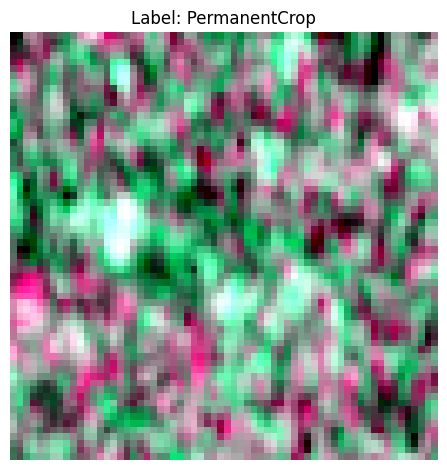

In [ ]:
head.eval()
sample = dataset_train[3]
x = sample['image'].unsqueeze(0).to(device)
lon = sample['lon'].unsqueeze(0).to(device)
lat = sample['lat'].unsqueeze(0).to(device)
time = torch.full_like(lon, torch.nan)
area = (16*10/1000)**2
area = torch.full((x.shape[0],), area).to(device)
meta_data = torch.stack((lon,lat,time,area),dim=-1)

with torch.no_grad():
  embedding = encoder(x, meta_data, wavelengths, bandwidths, language_embed=None, input_mode='spectral', kernel_size=kernel_size)
  pred = head(embedding)
  pred = torch.argmax(pred, dim=1).cpu().numpy()
pred_cls = dataset_train.classes[pred[0]]

print("Prediction:", pred_cls)
# Visualization
dataset_train.plot(sample).show()